In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [30]:
#Load datasets

def load_micron_ai_data(folder="loaded_data_df"):
    incoming_run_df = pd.read_parquet(os.path.join(folder, "incoming_run_df.parquet"))
    run_data_df = pd.read_parquet(os.path.join(folder, "run_data_df.parquet"))
    metrology_df = pd.read_parquet(os.path.join(folder, "metrology_df.parquet"))
    
    print("Loaded all 3 DataFrames from:", folder)
    return incoming_run_df, run_data_df, metrology_df

incoming_run_df, run_data_df, metrology_df = load_micron_ai_data()


Loaded all 3 DataFrames from: loaded_data_df


In [23]:
# Set display options for clarity
pd.set_option("display.max_columns", 100)

In [24]:
# -----------------------------------------------
# 🔧 Function 1: EDA Dashboard for Any DataFrame
# -----------------------------------------------
def eda_dashboard(df, name="DataFrame", check_sensor=False, plot=True):
    print(f"\n📊 EDA Dashboard for: {name}")
    print("-" * 50)
    
    print(f"🔹 Shape: {df.shape}")
    print(f"🔹 Columns: {df.columns.tolist()}")

    print("\n📦 Data Types:")
    print(df.dtypes)

    print("\n🧼 Null Values:")
    print(df.isnull().sum().sort_values(ascending=False))

    print(f"\n🧾 Duplicate Rows: {df.duplicated().sum()}")

    print("\n📈 Summary Statistics:")
    display(df.describe(include='all'))

    if check_sensor and "SensorValue" in df.columns:
        print("\n🚨 Outlier Check — SensorValue:")
        print(df['SensorValue'].describe(percentiles=[.01, .25, .5, .75, .99]))
        if plot:
            sns.histplot(df['SensorValue'], bins=100, kde=True)
            plt.title(f"{name}: SensorValue Distribution")
            plt.show()

    if "Measurement" in df.columns:
        print("\n🎯 Outlier Check — Measurement:")
        print(df['Measurement'].describe(percentiles=[.01, .25, .5, .75, .99]))
        if plot:
            sns.histplot(df['Measurement'], bins=60, kde=True)
            plt.title(f"{name}: Measurement Distribution")
            plt.show()

    if "TimeStamp" in df.columns:
        try:
            df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], errors='coerce')
            print(f"\n⏱ Time range: {df['TimeStamp'].min()} to {df['TimeStamp'].max()}")
        except Exception as e:
            print("Could not convert TimeStamp:", e)

    print("-" * 50)

In [25]:
# -----------------------------------------------
# 🧽 Function 2: Data Cleaning
# -----------------------------------------------
def clean_sensor_df(df, is_metrology=False):
    df = df.copy()

    # Remove full-NaN rows
    df.dropna(how="all", inplace=True)

    # Parse TimeStamp
    if "TimeStamp" in df.columns:
        df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], errors='coerce')

    # Drop rows with null SensorValue or Measurement
    if "SensorValue" in df.columns:
        df = df[df["SensorValue"].notnull() & df["SensorValue"].between(-1e6, 1e6)]

    if is_metrology and "Measurement" in df.columns:
        df = df[df["Measurement"].notnull() & df["Measurement"].between(-1000, 1000)]

    # Fill missing ToolId/StepId with placeholder
    for col in ["ToolId", "StepId"]:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown")

    return df

In [26]:
# -----------------------------------------------
# 📉 Function 3: Drift Check (Train vs Test)
# -----------------------------------------------
def drift_check(train_df, test_df, col):
    print(f"\n📉 Drift Check: {col}")
    train_vals = train_df[col].value_counts(normalize=True)
    test_vals = test_df[col].value_counts(normalize=True)
    df_drift = pd.concat([train_vals, test_vals], axis=1, keys=["Train", "Test"]).fillna(0)
    df_drift["Diff"] = abs(df_drift["Train"] - df_drift["Test"])
    display(df_drift.sort_values("Diff", ascending=False).head(10))

In [27]:
# -----------------------------------------------
# 📊 Function 4: Save DF as Feather or Parquet
# -----------------------------------------------
def save_df(df, name, folder="cleaned_data"):
    os.makedirs(folder, exist_ok=True)
    feather_path = os.path.join(folder, f"{name}.feather")
    parquet_path = os.path.join(folder, f"{name}.parquet")
    df.to_feather(feather_path)
    df.to_parquet(parquet_path)
    print(f"✅ Saved: {feather_path} and {parquet_path}")


📊 EDA Dashboard for: incoming_run_df
--------------------------------------------------
🔹 Shape: (82896506, 9)
🔹 Columns: ['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

📦 Data Types:
Tool ID                   object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
Run ID                    object
Process Step              object
Step ID                   object
Time Stamp        datetime64[ns]
Sensor Name               object
Sensor Value             float32
dtype: object

🧼 Null Values:
Tool ID           0
Run Start Time    0
Run End Time      0
Run ID            0
Process Step      0
Step ID           0
Time Stamp        0
Sensor Name       0
Sensor Value      0
dtype: int64

🧾 Duplicate Rows: 0

📈 Summary Statistics:


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
count,82896506,82896506,82896506,82896506,82896506,82896506,82896506,82896506,8.289651e+07
unique,19,NaN,NaN,4140,1,8,NaN,41,NaN
top,8a1010f8-7e9e-52ba-8586-2eac7e68eaee,NaN,NaN,988a5f1a-5950-56b2-9bcf-29c5aea70677,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_5,NaN,Sensor_1,NaN
freq,4663135,NaN,NaN,22960,82896506,44557529,NaN,2021866,NaN
mean,NaN,2024-01-01 22:58:26.099650304,2024-01-01 23:10:50.835380480,NaN,NaN,NaN,2024-01-01 23:02:30.820433920,NaN,3.190349e+02
min,NaN,2023-12-31 00:00:00,2023-12-31 00:11:58,NaN,NaN,NaN,2023-12-31 00:00:00,NaN,-2.960740e+01
25%,NaN,2023-12-31 23:02:00,2023-12-31 23:14:32,NaN,NaN,NaN,2023-12-31 23:05:44,NaN,3.786640e+00
50%,NaN,2024-01-01 22:45:00,2024-01-01 22:57:30,NaN,NaN,NaN,2024-01-01 22:48:12,NaN,4.378229e+01
75%,NaN,2024-01-02 22:50:12,2024-01-02 23:02:34,NaN,NaN,NaN,2024-01-02 22:54:39,NaN,2.045364e+02
max,NaN,2024-01-03 23:43:15,2024-01-03 23:55:50,NaN,NaN,NaN,2024-01-03 23:51:13.000000002,NaN,2.043282e+04


--------------------------------------------------

📊 EDA Dashboard for: metrology_df
--------------------------------------------------
🔹 Shape: (202860, 9)
🔹 Columns: ['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']

📦 Data Types:
Run ID                    object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
X_index                    int32
Y_index                    int32
X                        float64
Y                        float64
Point Index                int64
Measurement              float64
dtype: object

🧼 Null Values:
Run ID            0
Run Start Time    0
Run End Time      0
X_index           0
Y_index           0
X                 0
Y                 0
Point Index       0
Measurement       0
dtype: int64

🧾 Duplicate Rows: 0

📈 Summary Statistics:


,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
count,202860,202860,202860,202860.000000,202860.000000,202860.000000,202860.000000,202860.00000,202860.000000
unique,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00970470-f2f4-5759-86c4-f31fe6abdc5a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2024-01-02 13:54:03.815217408,2024-01-02 14:06:38.815217152,24.428571,25.020408,-0.437318,3.186172,24.00000,10.223926
min,NaN,2024-01-01 00:00:00,2024-01-01 00:12:35,1.000000,1.000000,-143.877551,-143.877551,0.00000,9.871226
25%,NaN,2024-01-01 18:30:00,2024-01-01 18:42:35,14.000000,14.000000,-64.285714,-64.285714,12.00000,10.107717
50%,NaN,2024-01-02 13:52:45,2024-01-02 14:05:20,26.000000,26.000000,9.183673,9.183673,24.00000,10.178120
75%,NaN,2024-01-03 09:15:30,2024-01-03 09:28:05,36.000000,34.000000,70.408163,58.163265,36.00000,10.297302
max,NaN,2024-01-04 04:38:15,2024-01-04 04:50:50,48.000000,48.000000,143.877551,143.877551,48.00000,11.563465



🎯 Outlier Check — Measurement:
count    202860.000000
mean         10.223926
std           0.169777
min           9.871226
1%            9.984665
25%          10.107717
50%          10.178120
75%          10.297302
99%          10.777424
max          11.563465
Name: Measurement, dtype: float64


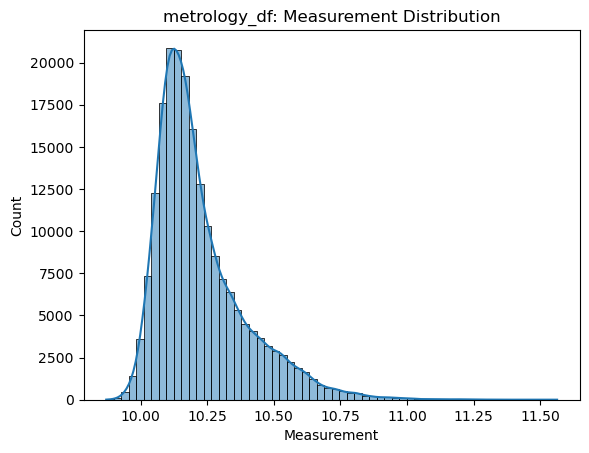

--------------------------------------------------


NameError: name 'run_data_test' is not defined

In [ ]:
# -----------------------------------------------
# Example Usage (in your notebook):
# -----------------------------------------------
eda_dashboard(incoming_run_df, name="incoming_run_df", check_sensor=True)
incoming_clean = clean_sensor_df(incoming_run_df)
# save_df(incoming_clean, "incoming_run")

eda_dashboard(metrology_df, name="metrology_df")
metrology_clean = clean_sensor_df(metrology_df, is_metrology=True)
#
drift_check(train_df=run_data_df, test_df=run_data_df, col="ToolId")


In [33]:
def micron_ai_eda_dashboard(df, name="DataFrame", is_sensor_df=False, show_plots=True):
    print(f"\n\U0001F4C8 EDA Dashboard for: {name}")
    print("-" * 60)

    # Shape, column names
    print(f"🔹 Shape: {df.shape}")
    print(f"🔹 Columns: {df.columns.tolist()}")

    # Data types
    print("\n📦 Data Types:")
    print(df.dtypes)

    # Null values
    print("\n🧼 Null Values:")
    print(df.isnull().sum().sort_values(ascending=False))

    # Duplicate rows
    print(f"\n🧾 Duplicate Rows: {df.duplicated().sum()}")

    # Summary statistics
    print("\n📊 Summary Statistics:")
    display(df.describe(include='all'))

    # Unique values for key columns
    for col in ['RunId', 'SensorName', 'ToolId', 'StepId']:
        if col in df.columns:
            print(f"🔢 Unique {col}: {df[col].nunique()}")

    # Outlier statistics
    if is_sensor_df and 'SensorValue' in df.columns:
        print("\n🚨 SensorValue Distribution:")
        print(df['SensorValue'].describe(percentiles=[.01, .25, .5, .75, .99]))
        if show_plots:
            sns.histplot(df['SensorValue'], bins=100, kde=True)
            plt.title(f"{name}: SensorValue Distribution")
            plt.show()
            sns.boxplot(x=df['SensorValue'])
            plt.title(f"{name}: SensorValue Boxplot")
            plt.show()

    elif 'Measurement' in df.columns:
        print("\n🎯 Measurement Distribution:")
        print(df['Measurement'].describe(percentiles=[.01, .25, .5, .75, .99]))
        if show_plots:
            sns.histplot(df['Measurement'], bins=50, kde=True)
            plt.title(f"{name}: Measurement Distribution")
            plt.show()
            sns.boxplot(x=df['Measurement'])
            plt.title(f"{name}: Measurement Boxplot")
            plt.show()

    # Time analysis
    if 'TimeStamp' in df.columns:
        try:
            df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
            print(f"\n⏳ Time range: {df['TimeStamp'].min()} to {df['TimeStamp'].max()}")
            if show_plots:
                sns.histplot(df['TimeStamp'].dropna(), bins=100)
                plt.title(f"{name}: TimeStamp Distribution")
                plt.xticks(rotation=45)
                plt.show()
        except Exception as e:
            print(f"Could not parse TimeStamp: {e}")

    print("-" * 60)

In [34]:
incoming_run_df, run_data_df, metrology_df = load_micron_ai_data()

Loaded all 3 DataFrames from: loaded_data_df


In [35]:
micron_ai_eda_dashboard(incoming_run_df, "Incoming Run Data", is_sensor_df=True)


📈 EDA Dashboard for: Incoming Run Data
------------------------------------------------------------
🔹 Shape: (82896506, 9)
🔹 Columns: ['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

📦 Data Types:
Tool ID                   object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
Run ID                    object
Process Step              object
Step ID                   object
Time Stamp        datetime64[ns]
Sensor Name               object
Sensor Value             float32
dtype: object

🧼 Null Values:
Tool ID           0
Run Start Time    0
Run End Time      0
Run ID            0
Process Step      0
Step ID           0
Time Stamp        0
Sensor Name       0
Sensor Value      0
dtype: int64

🧾 Duplicate Rows: 0

📊 Summary Statistics:


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
count,82896506,82896506,82896506,82896506,82896506,82896506,82896506,82896506,8.289651e+07
unique,19,NaN,NaN,4140,1,8,NaN,41,NaN
top,8a1010f8-7e9e-52ba-8586-2eac7e68eaee,NaN,NaN,988a5f1a-5950-56b2-9bcf-29c5aea70677,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_5,NaN,Sensor_1,NaN
freq,4663135,NaN,NaN,22960,82896506,44557529,NaN,2021866,NaN
mean,NaN,2024-01-01 22:58:26.099650304,2024-01-01 23:10:50.835380480,NaN,NaN,NaN,2024-01-01 23:02:30.820433920,NaN,3.190349e+02
min,NaN,2023-12-31 00:00:00,2023-12-31 00:11:58,NaN,NaN,NaN,2023-12-31 00:00:00,NaN,-2.960740e+01
25%,NaN,2023-12-31 23:02:00,2023-12-31 23:14:32,NaN,NaN,NaN,2023-12-31 23:05:44,NaN,3.786640e+00
50%,NaN,2024-01-01 22:45:00,2024-01-01 22:57:30,NaN,NaN,NaN,2024-01-01 22:48:12,NaN,4.378229e+01
75%,NaN,2024-01-02 22:50:12,2024-01-02 23:02:34,NaN,NaN,NaN,2024-01-02 22:54:39,NaN,2.045364e+02
max,NaN,2024-01-03 23:43:15,2024-01-03 23:55:50,NaN,NaN,NaN,2024-01-03 23:51:13.000000002,NaN,2.043282e+04


------------------------------------------------------------


In [36]:
micron_ai_eda_dashboard(run_data_df, "Run Data", is_sensor_df=True)


📈 EDA Dashboard for: Run Data
------------------------------------------------------------
🔹 Shape: (41220750, 10)
🔹 Columns: ['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Consumable Life', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

📦 Data Types:
Tool ID                    object
Run Start Time     datetime64[ns]
Run End Time       datetime64[ns]
Run ID                     object
Process Step               object
Consumable Life           float32
Step ID                    object
Time Stamp         datetime64[ns]
Sensor Name                object
Sensor Value              float32
dtype: object

🧼 Null Values:
Tool ID            0
Run Start Time     0
Run End Time       0
Run ID             0
Process Step       0
Consumable Life    0
Step ID            0
Time Stamp         0
Sensor Name        0
Sensor Value       0
dtype: int64

🧾 Duplicate Rows: 0

📊 Summary Statistics:


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Consumable Life,Step ID,Time Stamp,Sensor Name,Sensor Value
count,41220750,41220750,41220750,41220750,41220750,4.122075e+07,41220750,41220750,41220750,4.122075e+07
unique,19,NaN,NaN,4140,1,NaN,13,NaN,15,NaN
top,5116a75f-0543-502f-8278-2b2496d337d2,NaN,NaN,1483d37a-520e-5851-96eb-b8a22234b7c9,22c8716b-1c14-525a-8c0a-0473ec7aa99e,NaN,Step_5,NaN,Sensor_A,NaN
freq,2253105,NaN,NaN,10995,41220750,NaN,16487145,NaN,2748050,NaN
mean,NaN,2024-01-02 13:52:46.073672192,2024-01-02 14:05:21.073666304,NaN,NaN,2.514611e+02,NaN,2024-01-02 13:58:18.966889472,NaN,7.156060e+02
min,NaN,2024-01-01 00:00:00,2024-01-01 00:12:35,NaN,NaN,5.155509e-01,NaN,2024-01-01 00:00:00,NaN,-1.463412e+09
25%,NaN,2024-01-01 18:30:00,2024-01-01 18:42:35,NaN,NaN,1.456270e+02,NaN,2024-01-01 18:39:08,NaN,6.949232e+00
50%,NaN,2024-01-02 13:52:45,2024-01-02 14:05:20,NaN,NaN,2.530453e+02,NaN,2024-01-02 13:53:16,NaN,1.478311e+02
75%,NaN,2024-01-03 08:57:55,2024-01-03 09:10:30,NaN,NaN,3.604619e+02,NaN,2024-01-03 09:09:15,NaN,7.434313e+02
max,NaN,2024-01-04 04:38:15,2024-01-04 04:50:50,NaN,NaN,4.942603e+02,NaN,2024-01-04 04:50:18,NaN,3.913374e+08


------------------------------------------------------------



📈 EDA Dashboard for: Metrology Data
------------------------------------------------------------
🔹 Shape: (202860, 9)
🔹 Columns: ['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']

📦 Data Types:
Run ID                    object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
X_index                    int32
Y_index                    int32
X                        float64
Y                        float64
Point Index                int64
Measurement              float64
dtype: object

🧼 Null Values:
Run ID            0
Run Start Time    0
Run End Time      0
X_index           0
Y_index           0
X                 0
Y                 0
Point Index       0
Measurement       0
dtype: int64

🧾 Duplicate Rows: 0

📊 Summary Statistics:


,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
count,202860,202860,202860,202860.000000,202860.000000,202860.000000,202860.000000,202860.00000,202860.000000
unique,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00970470-f2f4-5759-86c4-f31fe6abdc5a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2024-01-02 13:54:03.815217408,2024-01-02 14:06:38.815217152,24.428571,25.020408,-0.437318,3.186172,24.00000,10.223926
min,NaN,2024-01-01 00:00:00,2024-01-01 00:12:35,1.000000,1.000000,-143.877551,-143.877551,0.00000,9.871226
25%,NaN,2024-01-01 18:30:00,2024-01-01 18:42:35,14.000000,14.000000,-64.285714,-64.285714,12.00000,10.107717
50%,NaN,2024-01-02 13:52:45,2024-01-02 14:05:20,26.000000,26.000000,9.183673,9.183673,24.00000,10.178120
75%,NaN,2024-01-03 09:15:30,2024-01-03 09:28:05,36.000000,34.000000,70.408163,58.163265,36.00000,10.297302
max,NaN,2024-01-04 04:38:15,2024-01-04 04:50:50,48.000000,48.000000,143.877551,143.877551,48.00000,11.563465



🎯 Measurement Distribution:
count    202860.000000
mean         10.223926
std           0.169777
min           9.871226
1%            9.984665
25%          10.107717
50%          10.178120
75%          10.297302
99%          10.777424
max          11.563465
Name: Measurement, dtype: float64


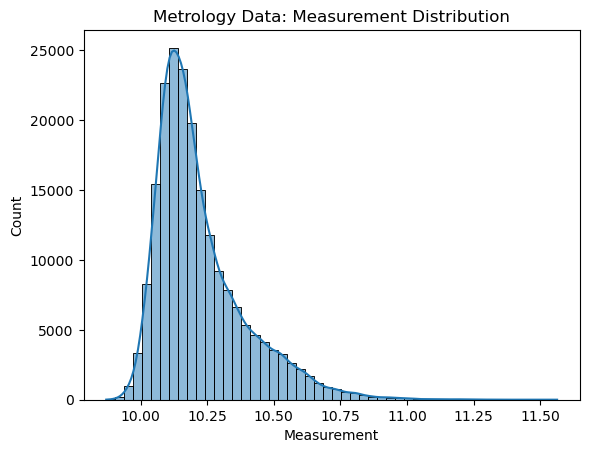

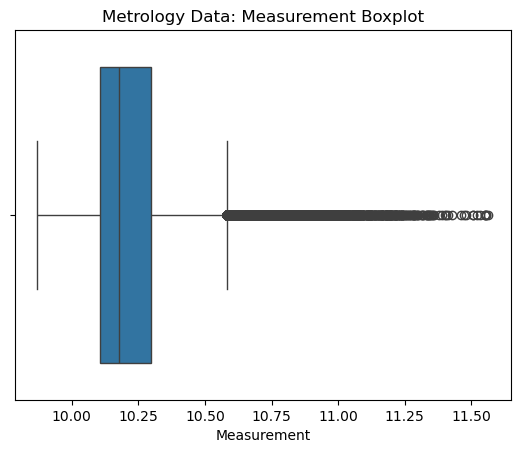

------------------------------------------------------------


In [37]:
micron_ai_eda_dashboard(metrology_df, "Metrology Data", is_sensor_df=False)


📊 Metrology Data EDA Summary (Measurement Target)
🧪 Measurement Distribution:

The distribution is right-skewed (positively skewed), peaking around 10.2.

A long tail extends beyond 10.5, with some values over 11.5.

The boxplot shows many outliers beyond ~10.5.

📌 Insights:

Measurement is not normally distributed.

There are outliers beyond 10.5 — but not necessarily errors (wafer behavior can vary).

You could:

Normalize or log-transform Measurement if using regression.

Apply a robust loss function or quantile regression to handle skew.

📈 Incoming Run Data EDA Summary
🧩 Shape: 82M rows, 9 columns

No missing values or duplicates. ✅

41 unique sensors, 19 tools, 8 step IDs — good sensor diversity.

Sensor Value ranges from −29.6 to 20,432 with a massive standard deviation of 725.

Mean = 319; 75% = 204 → confirms a strong right skew.

TimeStamps range from 2023-12-31 to 2024-01-03 — valid.

Step ID: Only 8 unique values → worth checking alignment with metrology steps.

📌 Concerns:

Sensor Value has extreme outliers (max > 20,000).

Outliers should be clipped, or robust scaling used.

We should probably:

Clip values above 99.9th percentile.

Plot a per-sensor boxplot for better granularity.

⚙️ Run Data EDA Summary
🧩 Shape: 41M rows, 10 columns

Sensor Value: min = −1.4e9, max = 3.9e8 🤯 — clearly corrupted values!

Typical values (25% to 75%) are ~6 to 743 — those huge extremes are anomalies.

Consumable Life ranges 0.5 to 494 — looks okay.

15 sensors only (vs 41 in incoming run) → run stage has fewer sensors.

📌 Action Needed:

Definitely clean SensorValue:

Remove or clip absurd values (e.g., anything outside ±10,000)

Use per-sensor logic if available (e.g., check expected range of Sensor_A vs Sensor_B)

Plot sensor-specific distributions.

🧬 Metrology Data (target + spatial features)
Exactly 49 measurements per Run ID → good.

Measurement is centered ~10.2, but again skewed.

Measurement correlates with (X, Y) position (check heatmap).

X and Y range from −143 to +143 → wafer coordinate system.

Point Index from 0 to 48 → consistent.

📌 Suggestion:

Include (X, Y), (X_index, Y_index), and PointIndex as features.

Consider generating radial distance from center (for symmetry modeling).

#### Why Should You Clean SensorValue?
Because you're seeing extreme values in run_data_df like:

Min: −1.46 billion

Max: +391 million

Mean: ~715

75th percentile: ~743

That’s a huge range, and most of it is likely noise, malfunction, or data corruption. These values can:

⚠️ Completely distort aggregation statistics like mean and std

⚠️ Break machine learning models (especially tree-based ones or linear regressors)

⚠️ Cause instability in feature importance, gradient updates, and even evaluation metrics

So even if you're aggregating SensorValue per RunId, these outliers will poison the results unless you clean them.

#### Should You Clean Before or After Concatenation?
we should clean it before aggregation. Why?

- Aggregation (mean, std, etc.) will be distorted if corrupted values are present.

- Cleaning after aggregation means you've already baked in the bad data.

- It's cheaper and safer to clean early — especially with time-series or sensor logs.


#### What Counts as “Outlier” in SensorValue?
3 common approaches:

Statistical Rule:

Use interquartile range (IQR): remove values outside Q1 − 3×IQR or Q3 + 3×IQR

Percentile Rule:

Remove anything below 0.1th percentile or above 99.9th percentile per sensor

Domain Rule (simple threshold):

Remove values where abs(SensorValue) > 10,000

Or define per-sensor limits if known